#  Battery model evaulation
In this script 5 battery models are evaluated

## Get packages and data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import scipy.optimize as sc
from scipy.ndimage import gaussian_filter1d
from scipy import signal
from tqdm import tqdm
from sklearn.metrics import r2_score
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import sys
sys.path.insert(0,'..')
from mtfunc.helper import *
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 5)
mpl.rcParams['axes.grid'] = True
day=24*60
hour=60
rdata0=pd.read_csv("/Users/adrianpaeckelripoll/rbc-parameter-tuning/data/battery_data.csv")
rdata0.timestamp=pd.to_datetime(rdata0.timestamp,unit='ns')

## Pre-process data

In [4]:
rdata=rdata0.set_index('timestamp').copy()
rdata['timeval']=rdata.index-rdata.index[0]
rdata['minutes']=rdata.timeval.apply(lambda x: x  / np.timedelta64(1,'m')).astype('int64') 
rdata.minutes=rdata.minutes-rdata.minutes[0]

# Define SoC as the mean of the min max measurements
rdata['soc'] = rdata[['soc_min', 'soc_max']].mean(axis=1)
rdata=rdata.drop(columns=['soc_min','soc_max','timeval'])
rdata=rdata.loc[(rdata.voltage>600) & (rdata.voltage<840)&(rdata.soc<90) & (rdata.soc>10)]
#Set sampling time to 1 min
dt=1
rdata=rdata.resample(f'{dt}T').mean().interpolate().dropna()
#Remove old data
rdata=rdata[pd.Timestamp('2019-03-15 00:00:00'):]
#Apply Gaussian filter to SoC and p_bat measurements
soc_fil_sig=2
rdata['soc_fil']=gaussian_filter1d(rdata.soc,sigma=soc_fil_sig)
rdata['power_t200_fil']=gaussian_filter1d(rdata.power_t200,sigma=soc_fil_sig/2)
#Calculate increments (for plotting later)
rdata['dsoc']=rdata.soc_fil.diff()
rdata['dP']=rdata.power_t200.diff()
rdata['dV']=rdata.voltage.diff()
rdata=rdata.dropna()

Remove data points where the measurement value is constant for more the 20min for the power and 18h for the SoC

In [6]:

m=rdata.dP==0
m=m.astype(int)
mask=pd.DataFrame(m.values,columns=['power_t200'],index=rdata.index)
m=rdata.dsoc==0
m=m.astype(int)
mask['soc']=m

wsize_power=int(20/dt) #20min
window = signal.windows.boxcar(wsize_power)
mask['power_t200']=signal.convolve(mask.power_t200.values,window,mode='same')/wsize_power

wsize_soc=int(18*60/dt) #18h
window = signal.windows.boxcar(wsize_soc)
mask['soc']=signal.convolve(mask.soc.values,window,mode='same')/wsize_soc
mask[mask<1]=0

mask.loc[pd.Timestamp('2021-10-01'):,'soc']=0


plt.figure(figsize=(20,5))
mask['tdata']=np.invert(mask.soc.values.astype(bool) | mask.power_t200.values.astype(bool))
mask.tdata.astype(int).plot()
plt.show()

tdata=rdata.loc[mask.tdata.values].copy()
#Remove old data
tdata=tdata[pd.Timestamp('2020-01-01'):pd.Timestamp('2021-09-10')].dropna()


## Crop valiation sets

In [8]:
# Training data crop from 2021-06-16 until today

# Validation data crop from 2021-04 until 2021-05-22

cvdata0=rdata[pd.Timestamp('2021-09-10'):pd.Timestamp('2021-09-14')].copy().dropna()
cvdata1=rdata[pd.Timestamp('2019-08-05'):pd.Timestamp('2019-08-09')].copy().dropna()

cvdata2=rdata[pd.Timestamp('2021-09-15'):pd.Timestamp('2021-09-19')].copy().dropna()
cvdata3=rdata[pd.Timestamp('2019-08-10'):pd.Timestamp('2019-08-14')].copy().dropna()

cvdata4=rdata[pd.Timestamp('2021-09-20'):pd.Timestamp('2021-09-24')].copy().dropna()
cvdata5=rdata[pd.Timestamp('2019-08-29'):pd.Timestamp('2019-09-2')].copy().dropna()

vdata0=rdata[pd.Timestamp('2021-06-20'):pd.Timestamp('2021-06-24')].copy().dropna()
vdata1=rdata[pd.Timestamp('2020-12-01'):pd.Timestamp('2020-12-05')].copy().dropna()

vdata2=rdata[pd.Timestamp('2021-06-25'):pd.Timestamp('2021-06-29')].copy().dropna()
vdata3=rdata[pd.Timestamp('2020-12-10'):pd.Timestamp('2020-12-15')].copy().dropna()

vdata4=rdata[pd.Timestamp('2021-06-15'):pd.Timestamp('2021-06-20')].copy().dropna()
vdata5=rdata[pd.Timestamp('2020-12-15'):pd.Timestamp('2020-12-20')].copy().dropna()

mdata=pd.concat([vdata0,vdata2,vdata3,vdata4,vdata5,cvdata0,cvdata2,cvdata3,cvdata4,cvdata5],axis=0)
print('Length of validation scope: ',len(mdata)*dt/day,'days')

Length of validation scope:  43.00694444444444 days


sns.pairplot(tdata[pd.Timestamp('2021-01-01'):pd.Timestamp('2021-03-10')])

## M1: $s_{k+1}-s_{k}=\phi_{0}+\phi_{1}p_{k}$

In [9]:
def model_1(s0,u,phi):
    y=np.array([s0])
    for p in tqdm(u.flatten()[:-1]):
        y=np.append(y,y[-1]+phi[0]+phi[1]*p)
    return y

    

Y=tdata.dsoc.values[1:]
sz=Y.shape[0]
Ht=np.ones((1,sz)) # bias phi0
Ht=np.append(Ht,tdata.power_t200_fil.shift().values[1:].reshape((1,sz)),axis=0) # p phi2
H=np.transpose(Ht)
phi1=np.dot(np.dot(np.linalg.inv(np.dot(Ht,H)),Ht),Y)
pd.DataFrame(phi1).to_csv('saved_models/phi1.csv',index=False)


## M2: $s_{k+1}-s_{k}=\phi_{0}+\phi_{1}\text{max}(0,p_{k})+\phi_{2}p_{k}$

In [10]:
def model_2(s0,u,phi):
    y=np.array([s0])
    for p in tqdm(u.flatten()[:-1]):
        y=np.append(y,y[-1]+phi[0]+phi[1]*max(0,p)+phi[2]*p)
    return y    

Y=tdata.dsoc.values[1:]
sz=Y.shape[0]
Ht=np.ones((1,sz)) # bias phi0
Ht=np.append(Ht,tdata.power_t200_fil.apply(lambda x: max(0,x)).shift().values[1:].reshape((1,sz)),axis=0) #max(0,p) phi1
Ht=np.append(Ht,tdata.power_t200_fil.shift().values[1:].reshape((1,sz)),axis=0) # p phi2
H=np.transpose(Ht)
phi2=np.dot(np.dot(np.linalg.inv(np.dot(Ht,H)),Ht),Y)
pd.DataFrame(phi2).to_csv('saved_models/phi2.csv',index=False)


## M3: $s_{k+1}-s_{k}=\phi_{0}+\phi_{1}\text{max}(-50,p_{k})+\phi_{2}\text{max}(0,p_{k})+\phi_{3}\text{max}(36,p_{k})+\phi_{4}p_{k}$

In [11]:
cut1=-50
cut2=36
def model_3(s0,u,phi):
    y=np.array([s0])
    for p in tqdm(u.flatten()[:-1]):
        y=np.append(y,y[-1]+phi[0]+phi[1]*max(cut1,p)+phi[2]*max(0,p)+phi[3]*max(cut2,p)+phi[4]*p)
    return y
  
Y=tdata.dsoc.values[1:]
sz=Y.shape[0]
Ht=np.ones((1,sz)) # bias phi0
Ht=np.append(Ht,tdata.power_t200_fil.apply(lambda x: max(cut1,x)).shift().values[1:].reshape((1,sz)),axis=0) #max(0,p) phi1
Ht=np.append(Ht,tdata.power_t200_fil.apply(lambda x: max(0,x)).shift().values[1:].reshape((1,sz)),axis=0) #max(0,p) phi1
Ht=np.append(Ht,tdata.power_t200_fil.apply(lambda x: max(cut2,x)).shift().values[1:].reshape((1,sz)),axis=0) #max(0,p) phi1
Ht=np.append(Ht,tdata.power_t200_fil.shift().values[1:].reshape((1,sz)),axis=0) # p phi2
H=np.transpose(Ht)
phi3=np.dot(np.dot(np.linalg.inv(np.dot(Ht,H)),Ht),Y)
pd.DataFrame(phi3).to_csv('saved_models/phi3.csv')


In [12]:
print(phi3)

[ 1.03851352e-01  6.80118971e-05 -8.90872764e-04 -2.99037088e-03
  1.62070862e-02]


## M4: Extended piece-wise linear (EPWL) 

In [13]:
par=np.asarray(pd.read_csv('PWLmodel_par_opti.csv',index_col='Unnamed: 0'))
def model_4(s0,u,x=par):
    cut1=x[5]
    cut2=x[6]
    y=np.array([s0])
    for p in u.flatten()[:-1]:

        dsoc=x[0]+x[1]*max(cut1,p)+x[2]*max(0,p)+x[3]*max(cut2,p)+x[4]*p
        if dsoc>x[9]: dsoc=x[7]*dsoc
        if dsoc<x[10]: dsoc=x[8]*dsoc        
        y=np.append(y,y[-1]+dsoc)

    return y

## ANN model 

In [14]:
dense=tf.keras.models.load_model('saved_models/p-dsoc_2-7-1_.h5')

2022-04-02 17:23:09.986639: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
def annmodel_1(s0,u,model):
    y=np.array([s0])
    dsoc=model.predict(u).flatten()
    for dy in dsoc[:-1]:
        y=np.append(y,y[-1]+dy)
    return y

In [16]:
def annmodel_2(s0,u,model):
    y=np.array([s0])
    dsoc=model.predict(u.reshape((1,len(u),1))).flatten()
    dsoc=np.insert(dsoc,0,dsoc[0])
    for dy in dsoc[:-1]:
        y=np.append(y,y[-1]+dy)
    return y

## Simulation

data[['soc_m1','soc_m2','soc_m3','soc_m4','soc_ann']].plot()

In [19]:
tdata['soc_m5']=annmodel_1(tdata.soc_fil.values[0],tdata.power_t200_fil.values,dense)
tdata['soc_m4']=model_4(tdata.soc_fil.values[0],tdata.power_t200_fil.values,par)
tdata['soc_m3']=model_3(tdata.soc_fil.values[0],tdata.power_t200_fil.values,phi3)
tdata['soc_m2']=model_2(tdata.soc_fil.values[0],tdata.power_t200_fil.values,phi2)
tdata['soc_m1']=model_1(tdata.soc_fil.values[0],tdata.power_t200_fil.values,phi1)


100%|█████████████████████████████████| 879391/879391 [07:05<00:00, 2066.26it/s]


In [25]:
tdata['dsoc_m5']=tdata.soc_m5.diff().shift(-1)
tdata['dsoc_m4']=tdata.soc_m4.diff().shift(-1)
tdata['dsoc_m1']=tdata.soc_m1.diff().shift(-1)
tdata['dsoc_m3']=tdata.soc_m3.diff().shift(-1)
tdata['dsoc_m2']=tdata.soc_m2.diff().shift(-1)
tdata.dropna(inplace=True)

In [76]:
tdata['error_dsoc_m5']=tdata.dsoc_m5-tdata.dsoc
tdata['error_dsoc_m2']=tdata.dsoc_m2-tdata.dsoc
# tdata[['error_dsoc_m5','error_dsoc_m2']].to_csv('/Users/adrianpaeckelripoll/rbc-parameter-tuning/fig_scripts/error_hist/error.csv',index=False)

_=plt.hist(tdata.error_dsoc_m2,bins=np.linspace(-0.3,0.3,100))
_=plt.hist(tdata.error_dsoc_m5,bins=np.linspace(-0.3,0.3,100))

In [26]:
tdata[['dsoc','dsoc_m4','dsoc_m1','power_t200_fil']].to_csv('/Users/adrianpaeckelripoll/rbc-parameter-tuning/fig_scripts/dsoc_P_fit/battery_dsoc_p.csv',index=False)

## Calculate metrics for plots

In [22]:
mdata.reset_index(inplace=True,drop=True)
day=24*60
mlist=[]
models=['soc_m1','soc_m2','soc_m3','soc_m4','soc_m5']
inter=1
# metrics and plots for each model at each day of the validation set mdata  

for k in range(mdata.shape[0]*dt//day//inter):
    print(k)
    if k in set((21,22,27,31,35,39)): continue
    data=mdata[inter*k*day:inter*k*day+day].copy()
    data=data[5:]
#     data['soc_m6']=annmodel_2(data.soc_fil.values[0],data.power_t200_fil.values,conv)
    data['soc_m5']=annmodel_1(data.soc_fil.values[0],data.power_t200_fil.values,dense)
    data['soc_m4']=model_4(data.soc_fil.values[0],data.power_t200_fil.values,par)
    data['soc_m3']=model_3(data.soc_fil.values[0],data.power_t200_fil.values,phi3)
    data['soc_m2']=model_2(data.soc_fil.values[0],data.power_t200_fil.values,phi2)
    data['soc_m1']=model_1(data.soc_fil.values[0],data.power_t200_fil.values,phi1)
    data[['soc_fil']+models].plot(figsize=(18,5),title=f'{k},  {inter*k*day},{inter*k*day+day}')
    mls=[]
    

    for col in models:
        #SoC metric
        mse=(data[col]-data.soc_fil)**2
        mse=mse.dropna().sum()/data.shape[0]
        mb=data[col]-data.soc_fil
        mb=mb.dropna().sum()/data.shape[0]
        mae=np.abs(data[col]-data.soc_fil).sum()/data.shape[0]
        r=r2_score(data[col],data.soc_fil)
        
        #dSoC metric
#         mse=(data[col].diff()-data.dsoc)**2
#         mse=mse.dropna().sum()/data.shape[0]
#         mb=data[col].diff()-data.dsoc
#         mb=mb.dropna().sum()/data.shape[0]
#         mae=np.abs(data[col].diff()-data.dsoc).sum()/data.shape[0]
#         r=r2_score(data.dsoc[1:],data[col].diff()[1:])     
        
        metrics=pd.DataFrame({col:[mb,mse,mae,r]},index=['bias','mse','mae','r2'])
        mls.append(metrics)
    metrics=pd.concat(mls,axis=1)   
    mlist.append(metrics)
metrics=pd.concat(mlist,axis=1)
import IPython.display
IPython.display.clear_output()

In [27]:
metrics.to_csv('/Users/adrianpaeckelripoll/rbc-parameter-tuning/figure_scripts/boxplot_battery_metrics/metrics.csv',index=True,index_label='index',)


## Evaluation mix

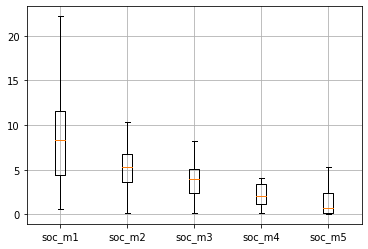

In [26]:
%matplotlib inline
for i,col in enumerate(models):    
    plt.boxplot(metrics[col].loc['mse'].values,showfliers=False,labels=[col],positions=[i])

In [56]:
meanlist=[]
stdlist=[]
for col in models:
    mean=pd.DataFrame({col[4:]:metrics[col].mean(axis=1)})
    std=pd.DataFrame({col[4:]:metrics[col].std(axis=1)})
    meanlist.append(mean)
    stdlist.append(std)
metrics_mean=pd.concat(meanlist,axis=1)
metrics_std=pd.concat(stdlist,axis=1)
# metrics_mean.to_csv('/Users/adrianpaeckelripoll/rbc-parameter-tuning/fig_data/metrics_mean.csv')
# metrics_std.to_csv('/Users/adrianpaeckelripoll/rbc-parameter-tuning/fig_data/metrics_std.csv')

In [57]:
metrics_mean.transpose().mse
metrics_std.transpose().mse.index


Index(['m1', 'm2', 'm3', 'm4', 'm5'], dtype='object')

<ErrorbarContainer object of 3 artists>

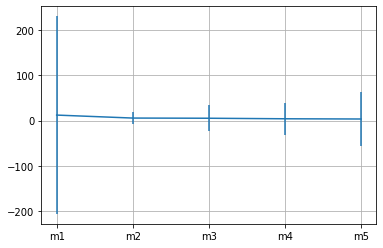

In [58]:
plt.errorbar(x=metrics_std.transpose().mse.index,y=metrics_mean.transpose().mse,yerr=np.square(metrics_std.transpose().mse.values))

pd.read_csv('/Users/adrianpaeckelripoll/rbc-parameter-tuning/fig_data/metrics_mean.csv')

metrics_mean.m4

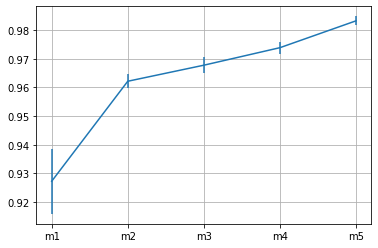

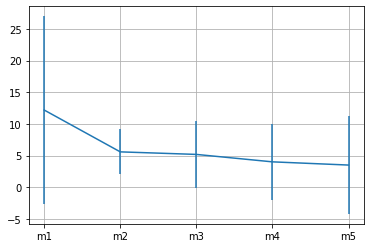

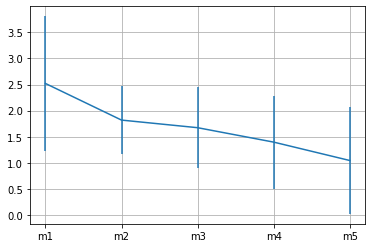

In [59]:
plt.errorbar(x=metrics_std.transpose().r2.index,y=metrics_mean.transpose().r2,yerr=np.square(metrics_std.transpose().r2.values))
plt.show()
plt.errorbar(x=metrics_std.transpose().mse.index,y=metrics_mean.transpose().mse,yerr=metrics_std.transpose().mse.values)
plt.show()
plt.errorbar(x=metrics_std.transpose().mae.index,y=metrics_mean.transpose().mae,yerr=metrics_std.transpose().mae.values)
plt.show()


Create model SoC daily data and plot it for 

## Simulations plots (daily SoC vs mmnt plot)

0


100%|████████████████████████████████████| 1434/1434 [00:00<00:00, 51975.73it/s]


1


100%|████████████████████████████████████| 1434/1434 [00:00<00:00, 54588.65it/s]


2


100%|████████████████████████████████████| 1434/1434 [00:00<00:00, 48778.89it/s]


3


100%|████████████████████████████████████| 1434/1434 [00:00<00:00, 43023.12it/s]


4


100%|████████████████████████████████████| 1434/1434 [00:00<00:00, 38395.60it/s]


5


100%|████████████████████████████████████| 1434/1434 [00:00<00:00, 30276.31it/s]


6


100%|████████████████████████████████████| 1434/1434 [00:00<00:00, 34430.51it/s]


7


100%|████████████████████████████████████| 1434/1434 [00:00<00:00, 42802.07it/s]


8


100%|████████████████████████████████████| 1434/1434 [00:00<00:00, 37602.26it/s]


9


100%|████████████████████████████████████| 1434/1434 [00:00<00:00, 41004.57it/s]


10


100%|████████████████████████████████████| 1434/1434 [00:00<00:00, 27706.86it/s]


11


100%|████████████████████████████████████| 1434/1434 [00:00<00:00, 36609.63it/s]


12


100%|████████████████████████████████████| 1434/1434 [00:00<00:00, 68273.61it/s]


13


100%|████████████████████████████████████| 1434/1434 [00:00<00:00, 39365.09it/s]


14


100%|████████████████████████████████████| 1434/1434 [00:00<00:00, 44283.85it/s]


15


100%|████████████████████████████████████| 1434/1434 [00:00<00:00, 44392.36it/s]


16


100%|████████████████████████████████████| 1434/1434 [00:00<00:00, 44571.32it/s]


17


100%|████████████████████████████████████| 1434/1434 [00:00<00:00, 47013.55it/s]


18


100%|████████████████████████████████████| 1434/1434 [00:00<00:00, 29654.44it/s]


19


100%|████████████████████████████████████| 1434/1434 [00:00<00:00, 28420.24it/s]


20


100%|████████████████████████████████████| 1434/1434 [00:00<00:00, 56299.38it/s]
/opt/anaconda3/envs/env1/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


21
22
23


100%|████████████████████████████████████| 1434/1434 [00:00<00:00, 38953.61it/s]


24


100%|████████████████████████████████████| 1434/1434 [00:00<00:00, 43850.57it/s]


25


100%|████████████████████████████████████| 1434/1434 [00:00<00:00, 39692.16it/s]


26


100%|████████████████████████████████████| 1434/1434 [00:00<00:00, 58993.01it/s]


27
28


100%|████████████████████████████████████| 1434/1434 [00:00<00:00, 40515.12it/s]


29


100%|████████████████████████████████████| 1434/1434 [00:00<00:00, 28427.63it/s]


30


100%|████████████████████████████████████| 1434/1434 [00:00<00:00, 32372.41it/s]


31
32


100%|████████████████████████████████████| 1434/1434 [00:00<00:00, 43003.74it/s]


33


100%|████████████████████████████████████| 1434/1434 [00:00<00:00, 56463.22it/s]


34


100%|████████████████████████████████████| 1434/1434 [00:00<00:00, 45159.64it/s]


35
36


100%|████████████████████████████████████| 1434/1434 [00:00<00:00, 35108.41it/s]


37


100%|████████████████████████████████████| 1434/1434 [00:00<00:00, 58305.05it/s]


38


100%|████████████████████████████████████| 1434/1434 [00:00<00:00, 54617.90it/s]


39
40


100%|████████████████████████████████████| 1434/1434 [00:00<00:00, 16545.30it/s]


41


100%|████████████████████████████████████| 1434/1434 [00:00<00:00, 35270.02it/s]


42


100%|████████████████████████████████████| 1434/1434 [00:00<00:00, 49602.76it/s]


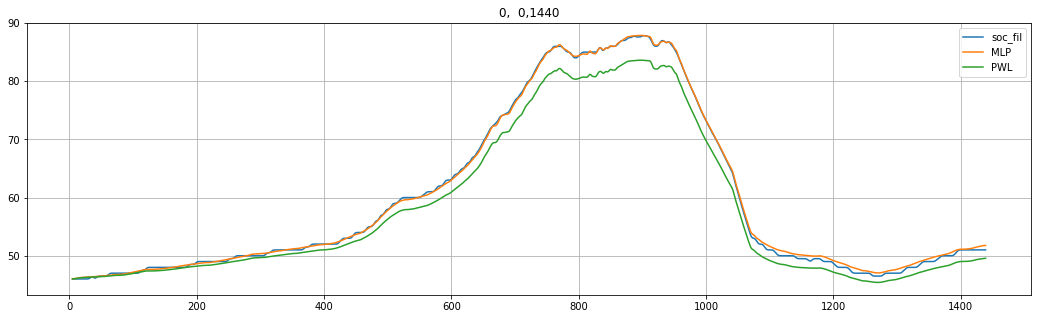

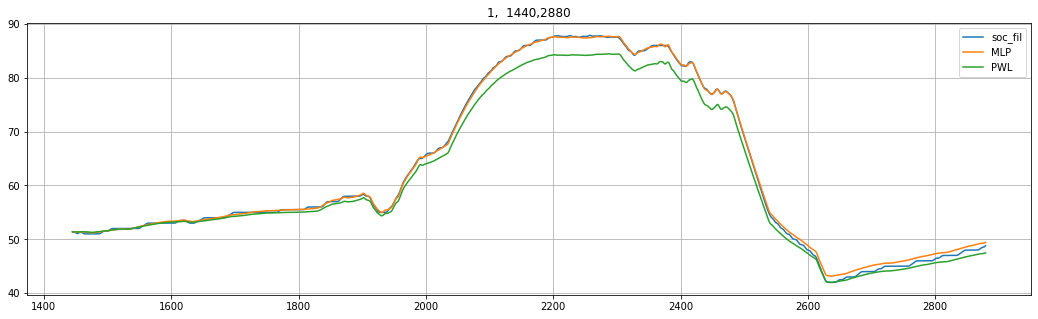

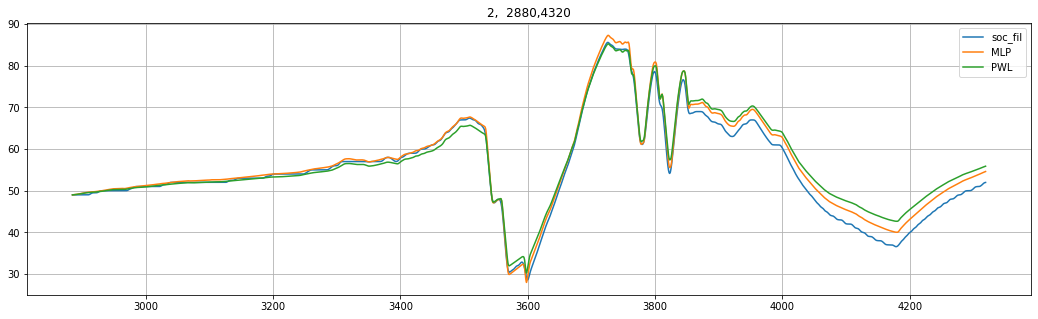

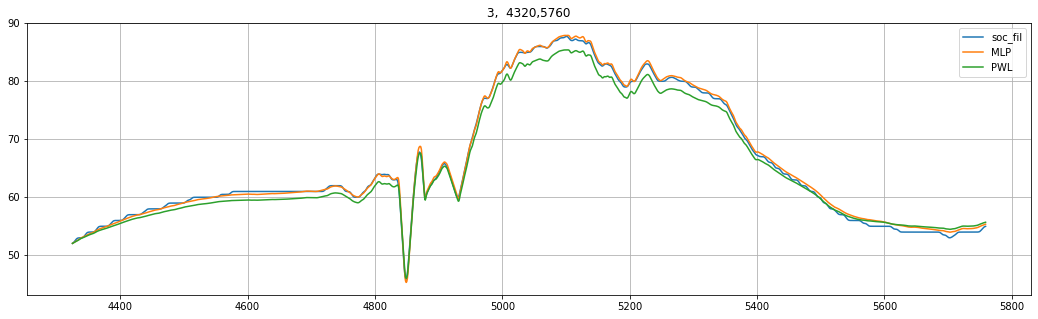

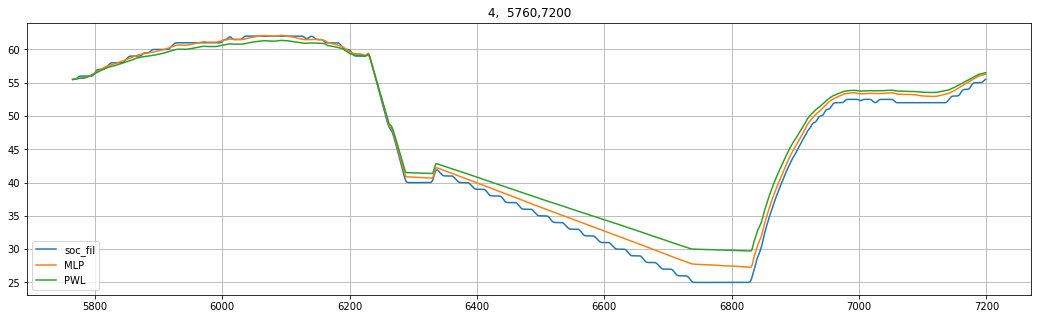

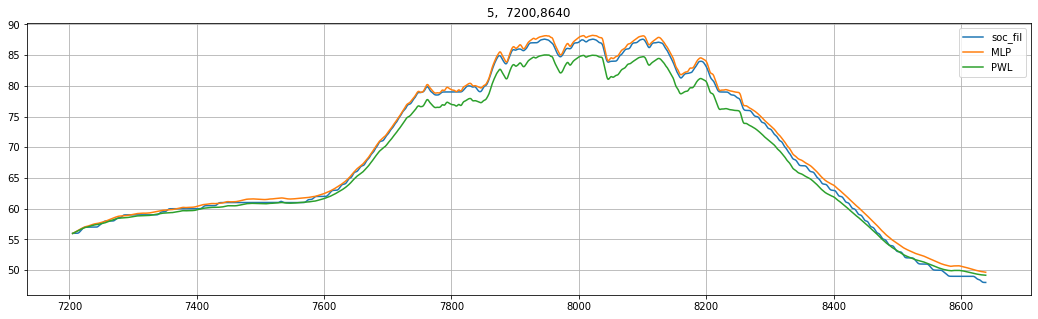

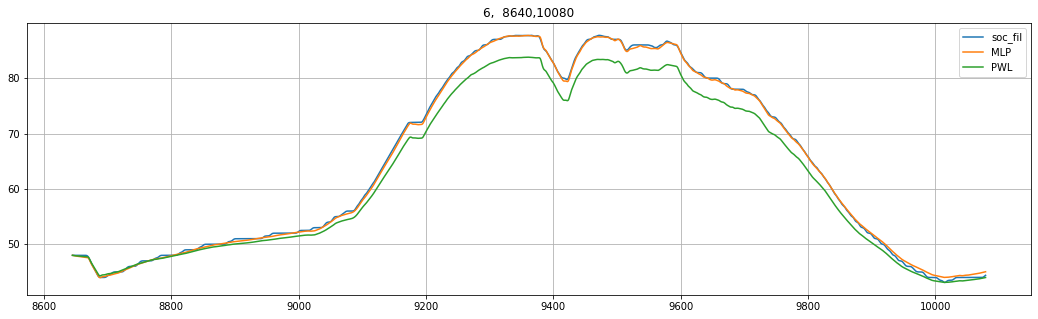

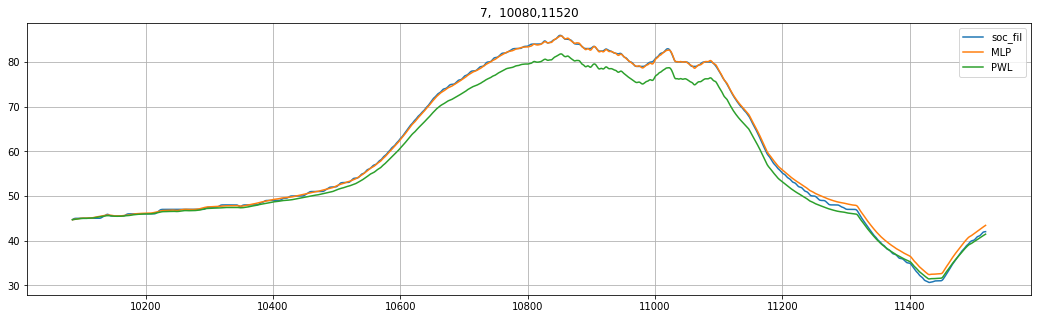

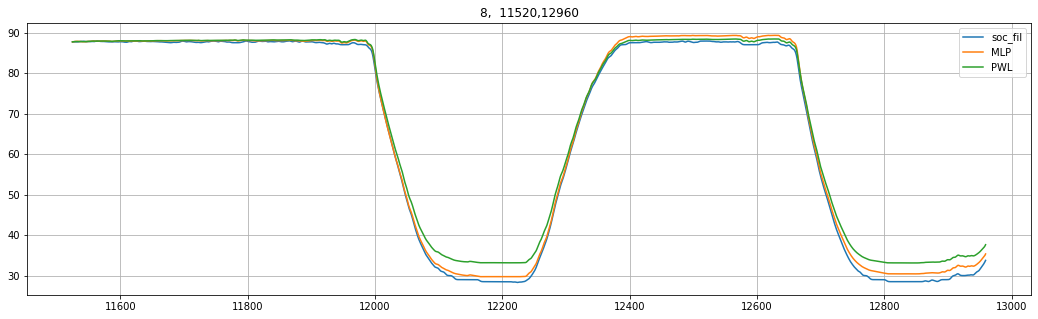

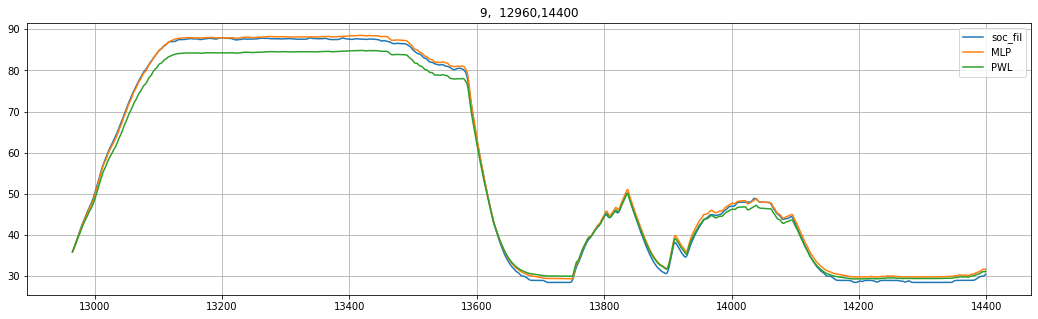

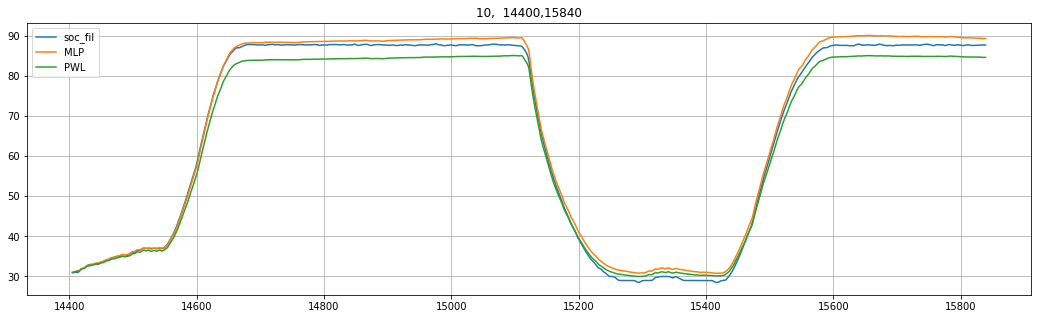

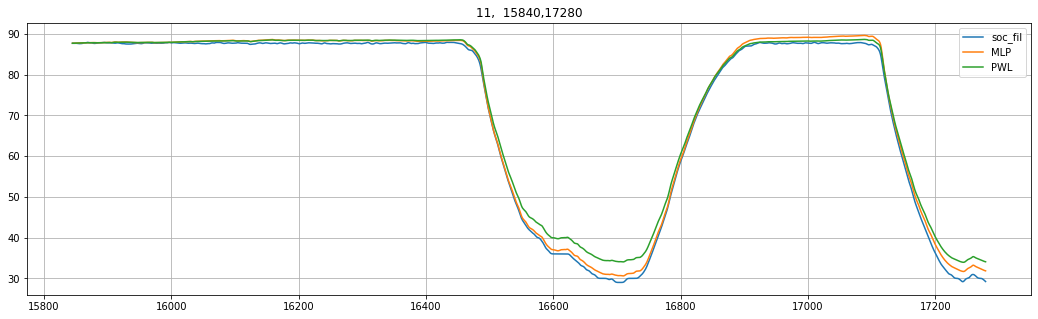

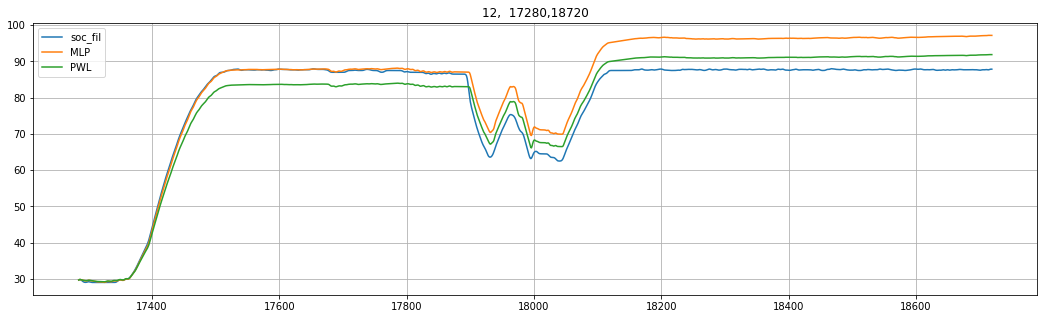

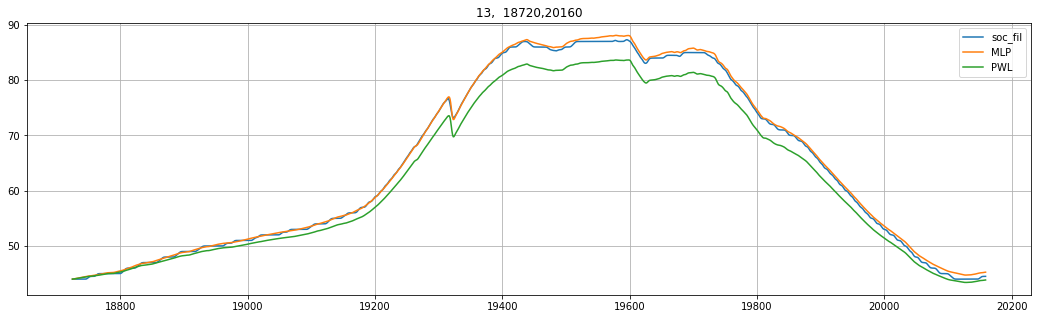

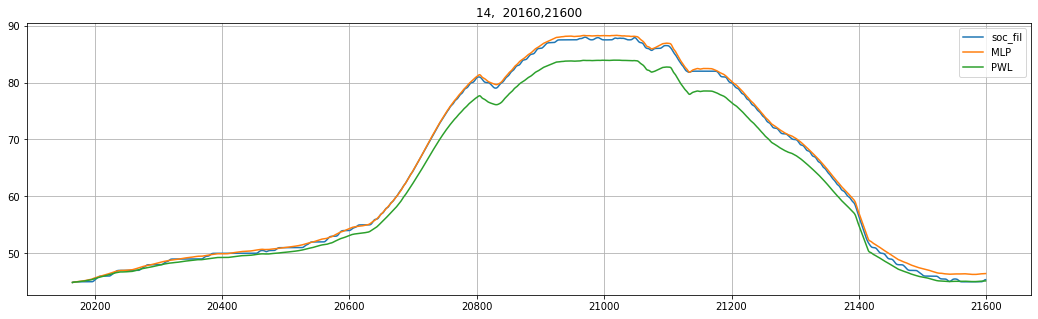

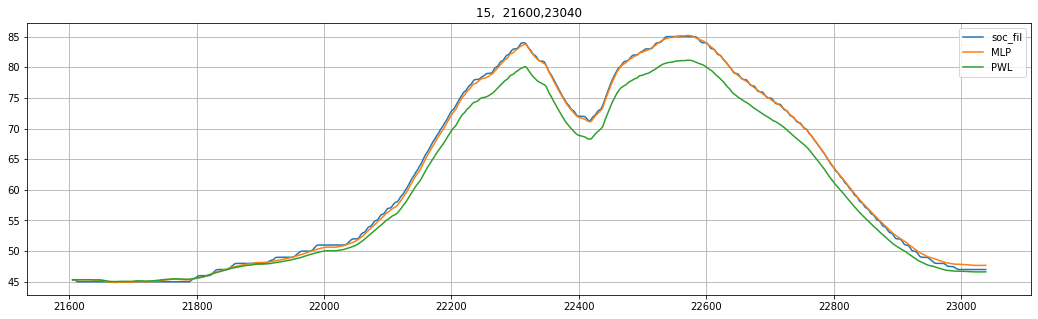

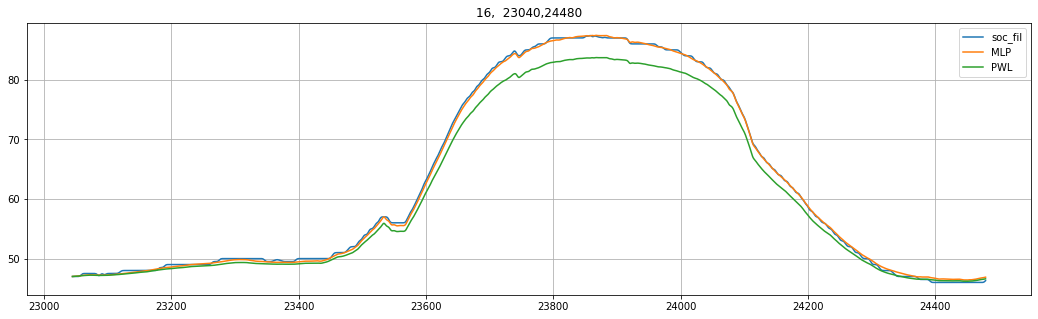

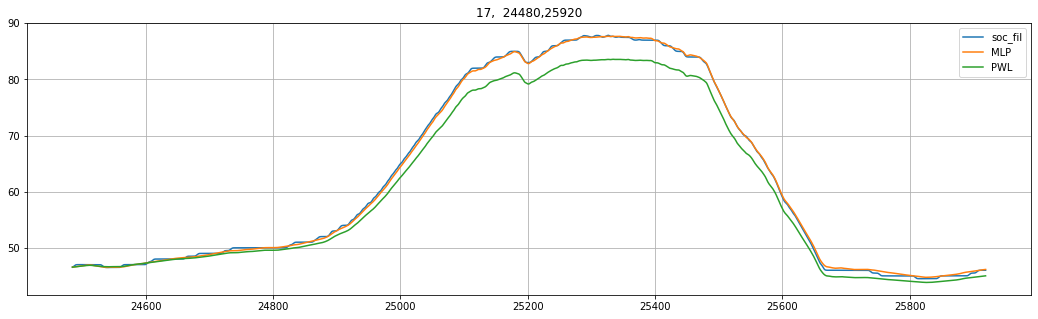

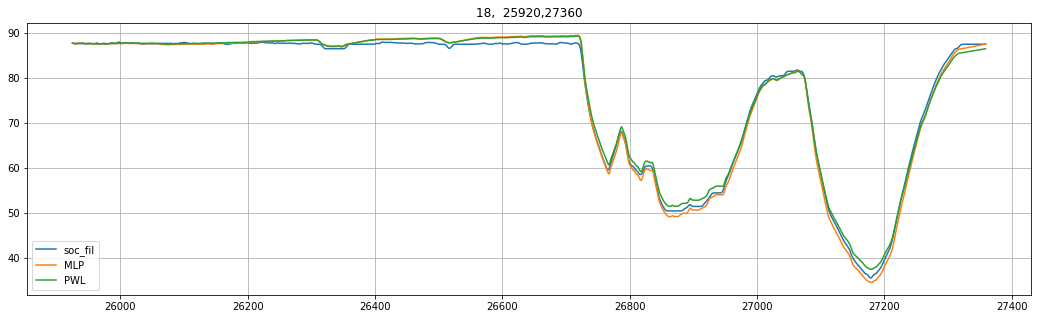

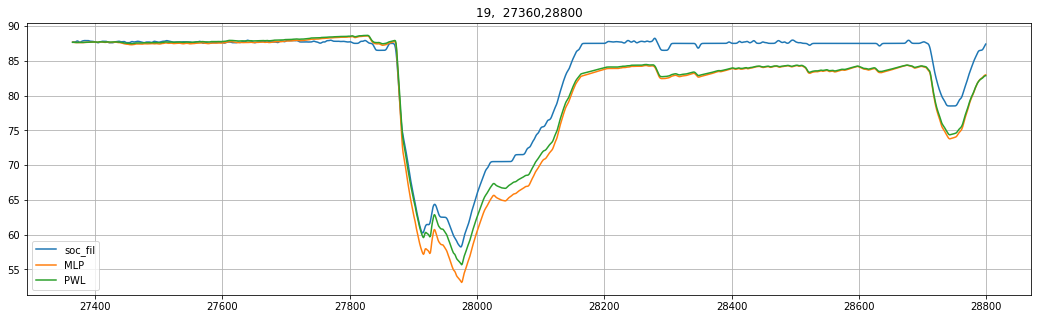

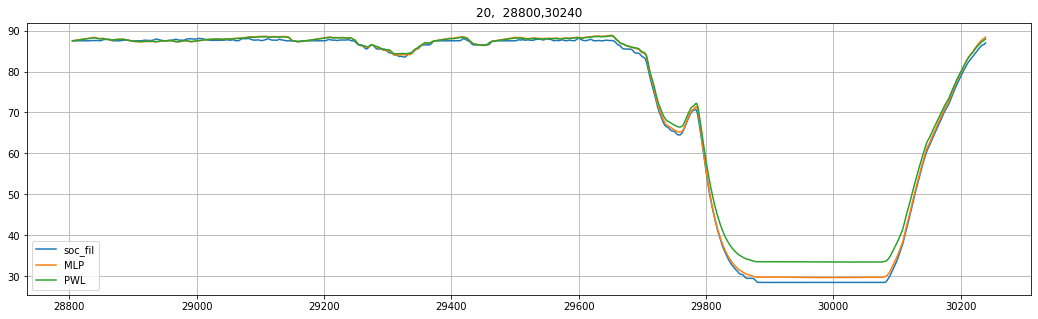

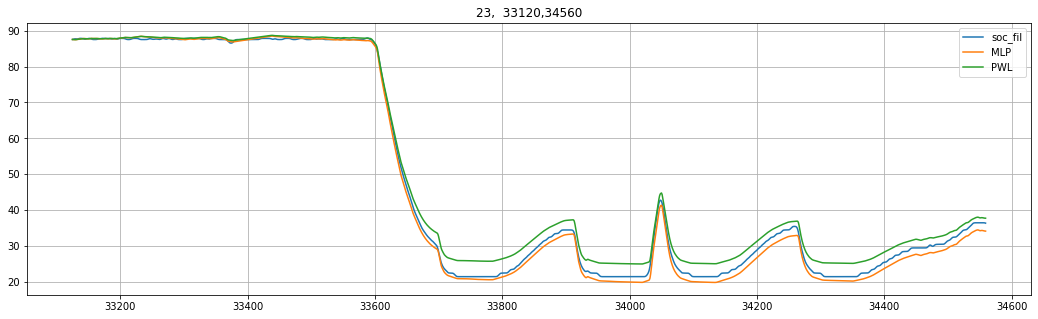

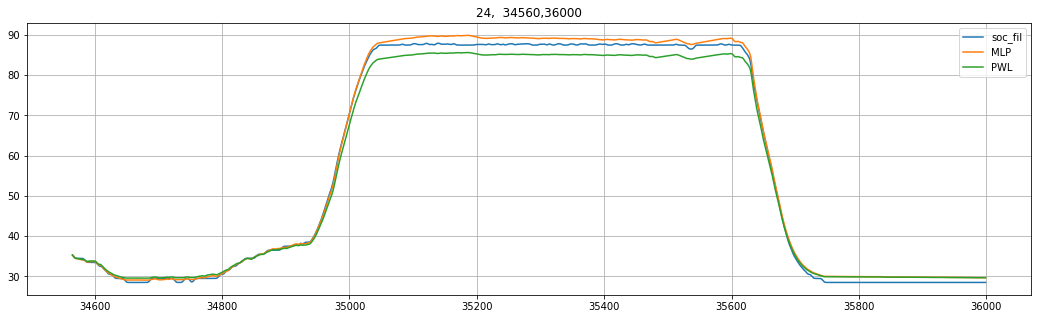

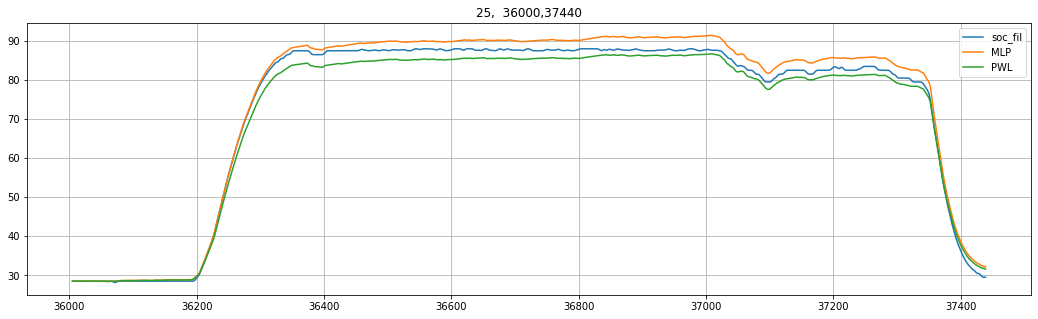

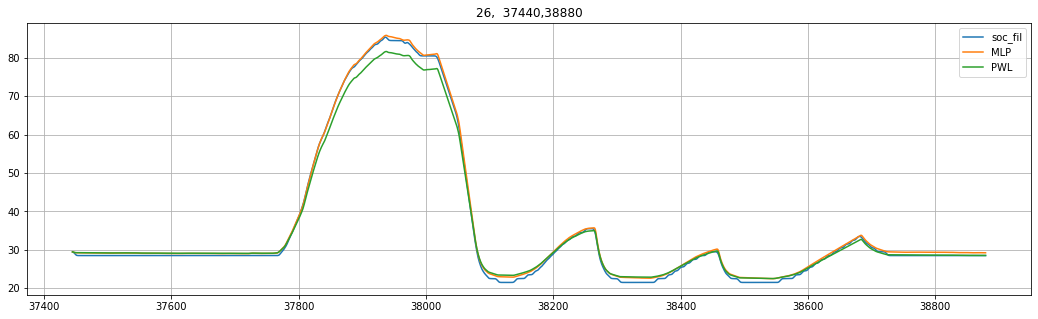

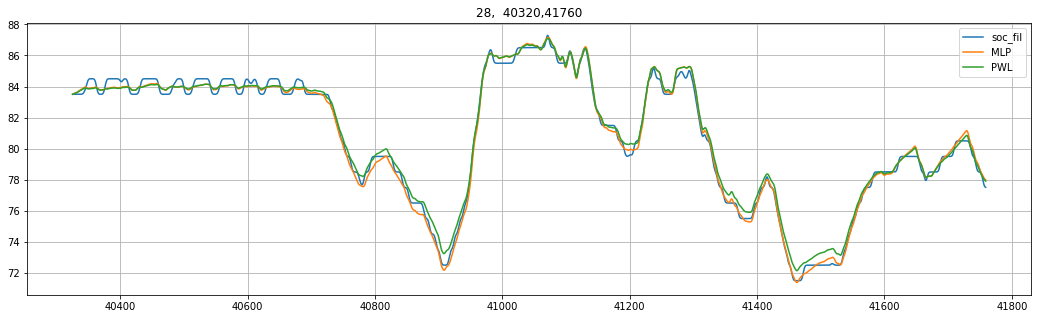

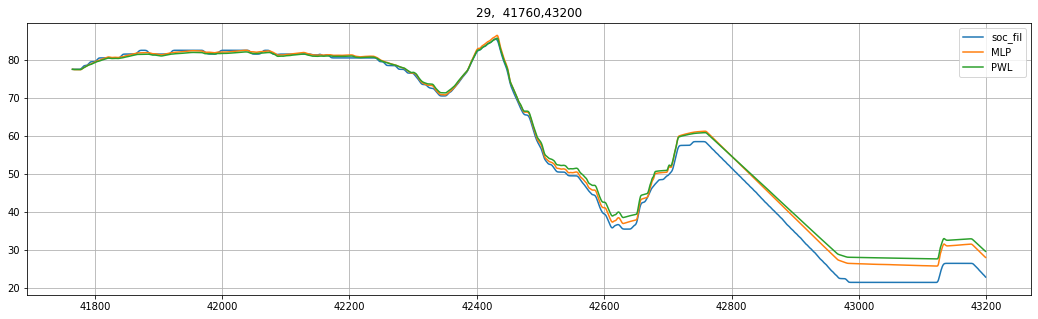

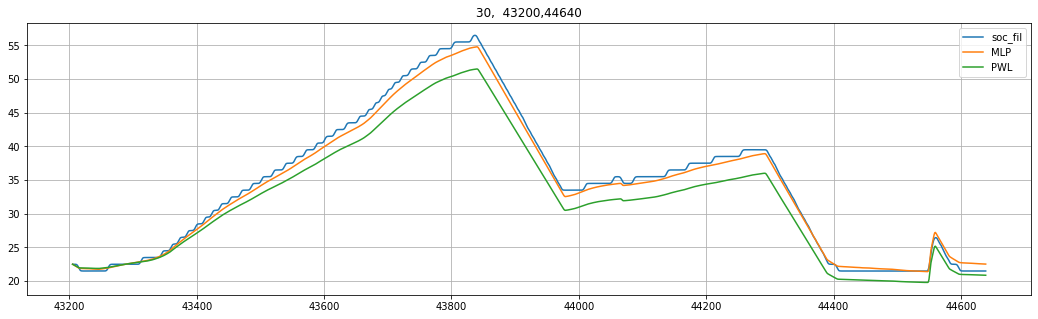

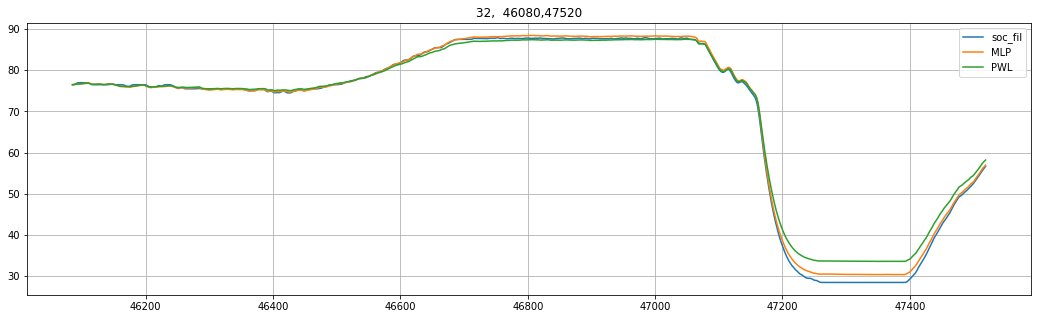

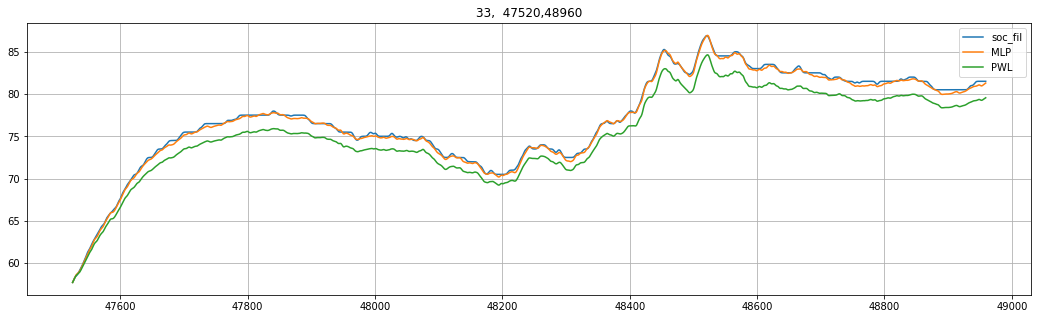

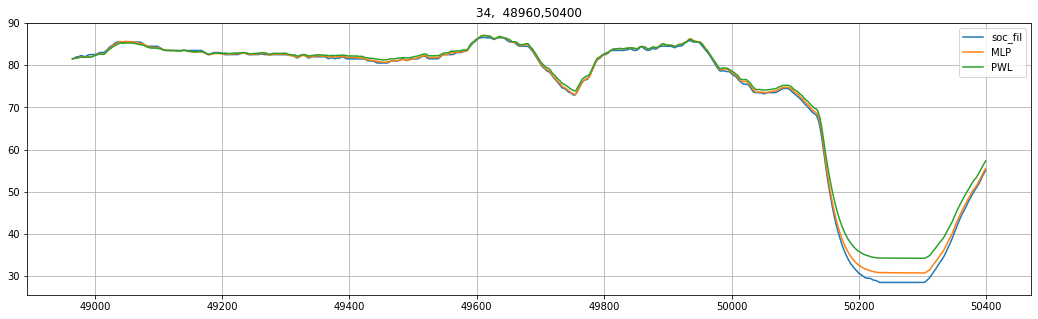

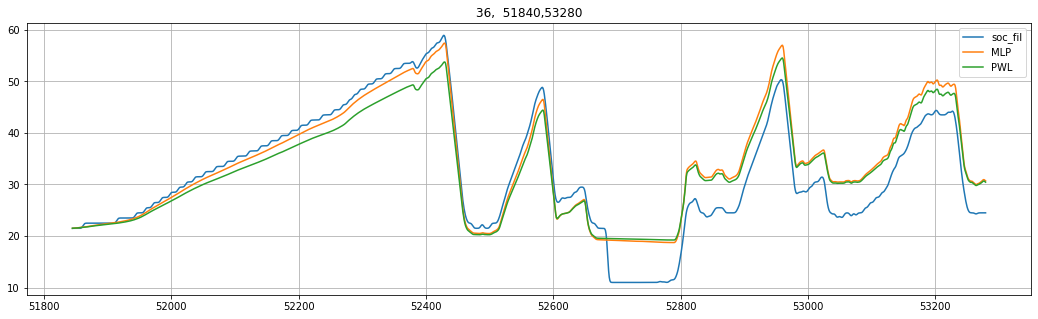

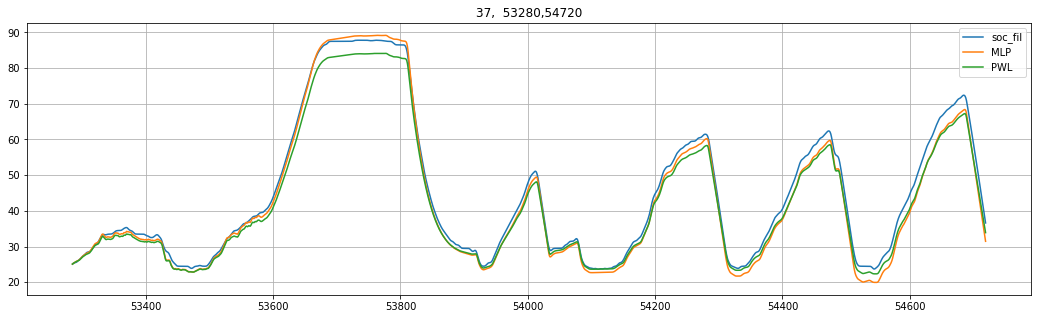

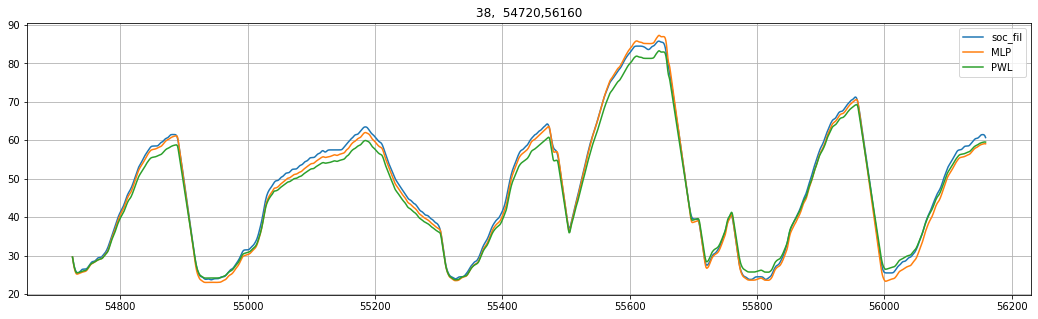

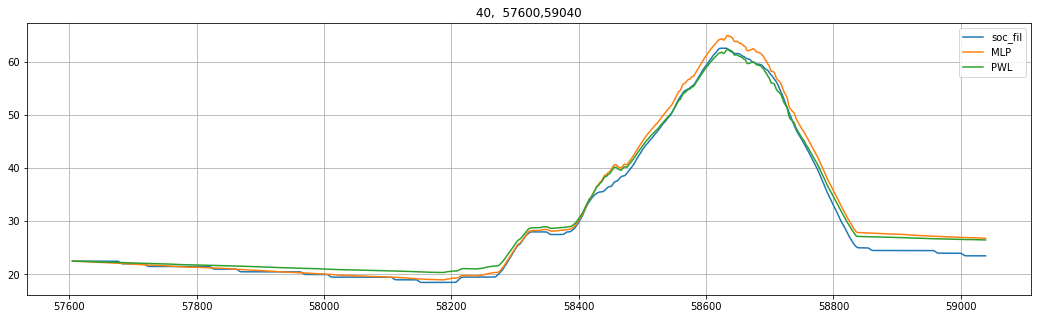

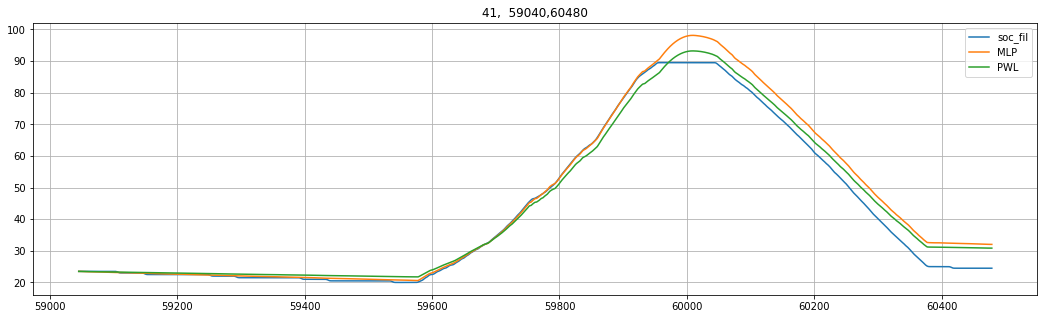

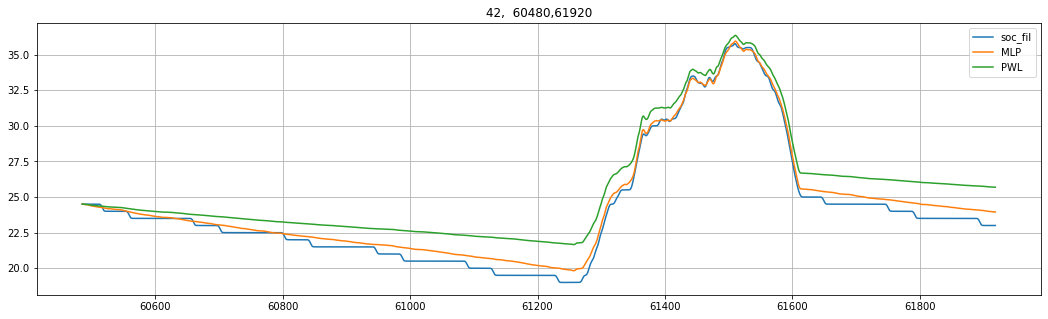

In [62]:
inter=1
# mdata.to_csv('validation_data.csv')
models=['PWL','MLP']
for k in range(mdata.shape[0]//day//inter):
    print(k)
    if k in set((21,22,27,31,35,39)): continue
    data=mdata[inter*k*day:inter*k*day+day].copy()
    data=data[5:]
#     data['soc_m6']=annmodel_2(data.soc_fil.values[0],data.power_t200_fil.values,conv)
    data['MLP']=annmodel_1(data.soc_fil.values[0],data.power_t200_fil.values,dense)
    data['PWL']=model_2(data.soc_fil.values[0],data.power_t200_fil.values,phi2)
    
    data[['soc_fil','MLP','PWL']].plot(figsize=(18,5),title=f'{k},  {inter*k*day},{inter*k*day+day}')
#     data[['soc_fil','MLP','PWL']].to_csv('/Users/adrianpaeckelripoll/rbc-parameter-tuning/fig_scripts/ES_models_day_fc/sim_day_%s.csv'%k,index_label='index')
    
    
    

In [ ]:
%matplotlib 
# models=['soc_model1','soc_model2','soc_model3','soc_model4','soc_model5','soc_model6','soc_fil','power_t200_fil']
models=['soc_model1','soc_model3','soc_model5','soc_model4','soc_fil']
model_names=['M%s'%x for x in range(1,5) ]+['mmnt']
columns=dict(zip(models,model_names))

cvdata[models].plot()
cvdata2.rename(columns=columns)[model_names].plot(markersize=10)
plt.ylabel('SoC')
vdata[models].plot()
vdata2.rename(columns=columns)[model_names].plot()
